In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhirupghosh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
stop_words=set(stopwords.words('english'))

In [7]:
df=pd.read_csv('../Data/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
print(f"Shape : {df.shape}")
print(f"Columns : {df.columns.to_list()}")

Shape : (159571, 8)
Columns : ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [12]:
label_cols=['toxic','severe_toxic','obscene','threat','insult','identity_hate']

print(f"Label Counts : {df[label_cols].sum()}")
print(f"Label Percentage : {(df[label_cols].mean()*100).round(2)}")

Label Counts : toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Label Percentage : toxic            9.58
severe_toxic     1.00
obscene          5.29
threat           0.30
insult           4.94
identity_hate    0.88
dtype: float64


#### **Exploratory Data Analysis**

Text(0, 0.5, 'Count')

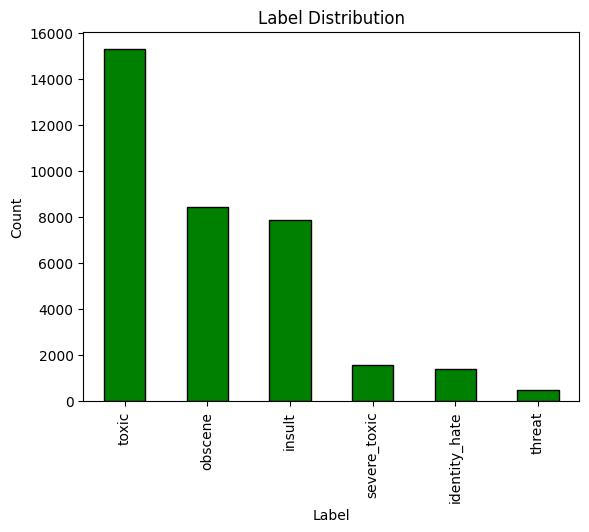

In [18]:
df[label_cols].sum().sort_values(ascending=False).plot(kind='bar',color='green',edgecolor='black')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

In [ ]:
df['clean']=(df[label_cols].sum(axis=1)==0).astype(int)

In [32]:
print(f"Clean Comment Percentage : {(df['clean'].mean()*100):.1f}%")
print(f"Toxic Comment Percentage : {100-df['clean'].mean()*100:.1f}%")

Clean Comment Percentage : 89.8%
Toxic Comment Percentage : 10.2%


Text(0.5, 1.0, 'Clean Vs Toxic Comments')

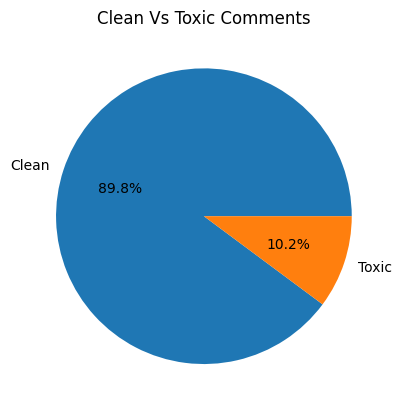

In [36]:
plt.pie([df['clean'].sum(),(1-df['clean']).sum()],labels=["Clean","Toxic"],autopct='%1.1f%%')
plt.title("Clean Vs Toxic Comments")

#### **Text Cleaning**

In [38]:
def clean_text(text):
    if pd.isnull(text):
        return ''
    text=text.lower()
    text=re.sub(r'http\S+|www\S+','',text)
    text=re.sub(r'\d+\.\d+\.\d+\.\d','',text)
    text=re.sub(r'[^a-zA-Z\s]','',text)
    text=re.sub(r'\s+',' ',text).strip()
    text=' '.join([word for word in text.split() if word not in stop_words])
    return text
    

In [39]:
df['cleaned_comment']=df['comment_text'].apply(clean_text)

In [ ]:
(df['cleaned_comment']=='').sum() # empty comments after cleaning

np.int64(66)

In [44]:
# Remove empty comments after cleaning
df=df[df['cleaned_comment']!=''].reset_index(drop=True)

In [45]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,cleaned_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page thats


#### **Tokenization**

In [46]:
tokenizer=Tokenizer(num_words=50000,oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_comment'])

print(f"Total Unique Words : {len(tokenizer.word_index)}")
print(f"Most Common Words : {list(tokenizer.word_index.items())[:10]}")

Total Unique Words : 216951
Most Common Words : [('<OOV>', 1), ('article', 2), ('page', 3), ('wikipedia', 4), ('talk', 5), ('please', 6), ('would', 7), ('one', 8), ('like', 9), ('dont', 10)]


In [47]:
sequences=tokenizer.texts_to_sequences(df['cleaned_comment'])
X=pad_sequences(sequences,maxlen=200,padding='post',truncating='post')

In [54]:
y=df[label_cols].values

#### **GloVe Embeddings**

In [55]:
def load_glove_embedding(file_path,word_index,max_words,embedding_dim):
    embedding_index={}
    with open(file_path,encoding='utf-8') as f:
        for line in f:
            values=line.split()
            word=values[0]
            vector=np.asarray(values[1:],dtype='float32')
            embedding_index[word]=vector
    print(f"Loaded {len(embedding_index)} vectors")

    embedding_matrix=np.zeros((max_words,embedding_dim))
    found=0
    for word,idx in word_index.items():
        if idx<max_words:
            vector=embedding_index.get(word)
            if vector is not None:
                embedding_matrix[idx]=vector
                found+=1
    print(f"Words matched in GloVe : {(found)/min(max_words,len(word_index))*100:.2f}%")
    print(f"Embedding Matrix shape : {embedding_matrix.shape}")

    return embedding_matrix


In [56]:
glove_path='/Users/abhirupghosh/Desktop/Abhirup/Toxic_Comment_Classification/Glove/glove.6B.100d.txt'
max_words=50000
embedding_dim=100
embedding_matrix=load_glove_embedding(glove_path,tokenizer.word_index,max_words,embedding_dim)

Loaded 400000 vectors
Words matched in GloVe : 82.40%
Embedding Matrix shape : (50000, 100)


In [59]:
SAVE_DIR = '../processed/'
os.makedirs(SAVE_DIR, exist_ok=True)

In [60]:
np.save(f"{SAVE_DIR}X.npy",X)
np.save(f"{SAVE_DIR}y.npy",y)
np.save(f"{SAVE_DIR}embedding_matrix.npy",embedding_matrix)

with open(f"{SAVE_DIR}tokenizer.pkl","wb") as f:
    pickle.dump(tokenizer,f)

for file in os.listdir(SAVE_DIR):
    print(f"{file}")

embedding_matrix.npy
X.npy
y.npy
tokenizer.pkl
